In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import flwr as fl
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from datasets import load_dataset
from flwr.client.mod import fixedclipping_mod
from flwr.server.strategy import (
    DifferentialPrivacyClientSideFixedClipping
)
from utils.utils import * 

In [16]:
cfg = get_config("federated")

In [17]:
partitioner = IidPartitioner(num_partitions=cfg.flower.num_clients)
fds = FederatedDataset(
    dataset=cfg.dataset.name,
    partitioners={"train": partitioner}
)

partition_zero = fds.load_partition(0) 

partition_zero

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 3396
})

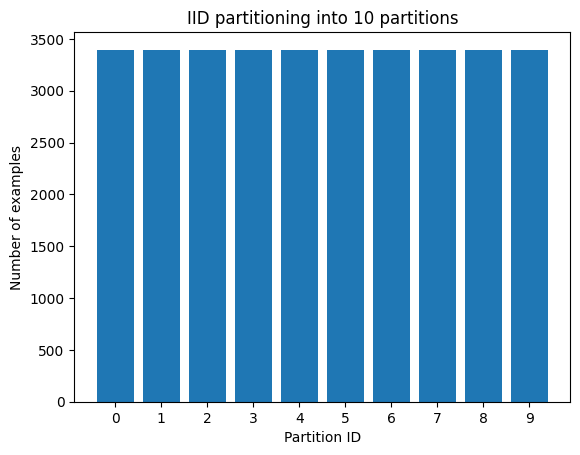

In [18]:
visualize_partitions(fds)

In [19]:
(
tokenizer,
data_collator,
formatting_prompts_func,
) = get_tokenizer_and_data_collator_and_propt_formatting(
    cfg.model.name, 
    cfg.model.use_fast_tokenizer,
    cfg.train.padding_side,
)

In [20]:
def gen_client_fn(
    fds,
    tokenizer,
    formatting_prompts_func,
    data_collator,
    model_cfg: DictConfig,
    train_cfg: DictConfig,
    save_path: str,
) -> Callable[[str], FlowerClient]:  # pylint: disable=too-many-arguments
    """Generate the client function that creates the Flower Clients."""

    def client_fn(context: Context) -> FlowerClient:
        """Create a Flower client representing a single organization."""

        # Let's get the partition corresponding to the i-th client
        partition_id = int(context.node_config["partition-id"])
        client_trainset = fds.load_partition(partition_id, "train")
        client_trainset = client_trainset.remove_columns(["instruction"])
        client_trainset = client_trainset.rename_column("input", "instruction")
        client_trainset = client_trainset.rename_column("output", "response")
        return FlowerClient(
            model_cfg,
            train_cfg,
            client_trainset,
            tokenizer,
            formatting_prompts_func,
            data_collator,
            save_path,
        ).to_client()

    return client_fn

In [21]:
save_path = "./my_fl_model"
client = fl.client.ClientApp(
    client_fn=gen_client_fn(
        fds,
        tokenizer,
        formatting_prompts_func,
        data_collator,
        cfg.model, 
        cfg.train, 
        save_path,
    )
)

In [22]:
def server_fn(context: Context):

    # Define the Strategy
    strategy = fl.server.strategy.FedAvg(
        min_available_clients=cfg.flower.num_clients, # total clients
        fraction_fit=cfg.flower.fraction_fit, # ratio of clients to sample
        fraction_evaluate=0.0, # No federated evaluation
        # A (optional) function used to configure a "fit()" round
        on_fit_config_fn=get_on_fit_config(),
        # A (optional) function to aggregate metrics sent by clients
        fit_metrics_aggregation_fn=fit_weighted_average,
        # A (optional) function to execute on the server after each round. 
        # In this example the function only saves the global model.
        evaluate_fn=get_evaluate_fn( 
            cfg.model,
            cfg.train.save_every_round,
            cfg.flower.num_rounds,
            save_path
        ),
    )

    '''
    # Add Differential Privacy
    sampled_clients = cfg.flower.num_clients*strategy.fraction_fit
    strategy = DifferentialPrivacyClientSideFixedClipping(
        strategy, 
        noise_multiplier=cfg.flower.dp.noise_mult,
        clipping_norm=cfg.flower.dp.clip_norm, 
        num_sampled_clients=sampled_clients
    )
    '''

    # Number of rounds to run the simulation
    num_rounds = cfg.flower.num_rounds
    config = fl.server.ServerConfig(num_rounds=num_rounds)
    
    return fl.server.ServerAppComponents(strategy=strategy, config=config) 

In [23]:
server = fl.server.ServerApp(server_fn=server_fn)

In [24]:
fl.simulation.run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=cfg.flower.num_clients,
     backend_config={"init_args": backend_setup}
)

INFO :      Starting Flower ServerApp, config: num_rounds=6, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0, {}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.0, {}, 238.2467623000266)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.0, {}, 522.9286470001098)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      config

In [31]:
# Load dataset
train_dataset = load_dataset(cfg.dataset.name, split='train')
# Select training example
example_index = 6
data_point = train_dataset[example_index]

In [32]:
prompt = data_point["input"]
prompt

'What are the possible causes of low glucose and high C-peptide levels?'

In [33]:
answer = data_point["output"]
answer

'Low glucose and high C-peptide levels can be caused by an insulinoma or the use of sulfonylurea drugs.'

In [34]:
model, tokenizer = load_pretrained_model(cfg.model.name)

Cargando el tokenizador para EleutherAI/pythia-70m...
Cargando el modelo preentrenado EleutherAI/pythia-70m...
El modelo ha sido cargado exitosamente en el dispositivo: cpu


In [36]:
answer1 = generate_text(model, tokenizer, data_point["input"], max_length=100)
print(answer1)

What are the possible causes of low glucose and high C-peptide levels?
: The main reason is that there may be a decrease in insulin secretion, which can lead to an increase or even death. In fact it has been suggested by other studies (eurotide et al., [@B31]; Kahnke & Hickman; @Kahler1) for example using serum albumin as well \[[@R32]\]. However this study did not find any significant differences between these two conditions


In [45]:
save_path = "./my_fl_model"
lora_adapter_path = f"{save_path}/peft_5/"

# Cargar el modelo combinado con el adaptador LoRA y el tokenizador
model_FL, tokenizer_FL = load_model_with_lora_adapter(cfg.model.name, lora_adapter_path)

Cargando el tokenizador para EleutherAI/pythia-70m...
Cargando el modelo preentrenado EleutherAI/pythia-70m...
Aplicando el adaptador LoRA desde ./my_fl_model/peft_5/...
trainable params: 0 || all params: 70,623,232 || trainable%: 0.0
El modelo combinado con el adaptador LoRA ha sido cargado exitosamente.


In [46]:
answer2 = generate_text(model_FL, tokenizer_FL, data_point["input"], max_length=100)
print(answer2)

What are the possible causes of low glucose and high C-peptide levels?

